In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SVR, Decision Tree, Ensemble Methods, LSTM, GRU

---




## Import Libraries

In [8]:
# !pip install plotly
# !pip install xgboost
# !pip install catboost
!pip install ngboost
!pip install shap

     |████████████████████████████████| 564 kB 7.5 MB/s 


In [9]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import os

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor, Pool
# from catboost.utils import eval_metric
from ngboost import NGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import cycle

import pickle

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

import shap

## Import Dataset

In [10]:
df = pd.read_csv('/content/drive/MyDrive/stock_price/datasets/pre_samsung_e_sent.csv', encoding='cp949')
df.head()

,Date,Close,foreign,volatility,consumption,yield_bond,snp500,fng,gold,copper,wti,pork,usd_krw,cny_krw,eur_krw,jpy_krw,covid,blob_score,norm_score,MA(5),MA(10)
0,2019-01-15,41100,6.272499e+10,14.85,1226.86,1213.68,2582.610107,16.0,46630.0,2.7050,50.51,61.85,112180.0,166.66,128743.0,10.3712,0.0,0.145900,0.25,40210.0,39170.0
1,2019-01-16,41450,5.514149e+10,14.95,1231.12,1214.15,2610.300049,27.0,46580.0,2.6920,52.11,62.15,112285.0,166.66,128159.0,10.3333,0.0,0.143432,0.25,40580.0,39440.0
2,2019-01-17,41950,5.733554e+10,14.60,1223.33,1213.56,2616.100098,24.0,46580.0,2.7205,52.31,60.05,112078.0,166.66,127763.0,10.2735,0.0,0.146456,0.25,41010.0,39875.0
3,2019-01-18,42300,1.302985e+11,15.00,1208.55,1213.32,2635.959961,28.0,46700.0,2.7350,52.07,60.85,112270.0,166.66,127926.0,10.2774,0.0,0.135738,0.25,41370.0,40360.0
4,2019-01-21,42750,6.033419e+10,14.70,1223.86,1211.02,2670.709961,29.0,46700.0,2.7645,53.80,61.23,112608.0,166.66,127957.0,10.2581,0.0,0.131072,0.25,41910.0,40760.0


In [12]:
del df['MA(5)']
# del df['MA(20)']
# del df['MA(30)']
del df['blob_score']
del df['norm_score']
df.head()

KeyError: ignored

# 3년

# Prepare Data for Analysis

In [13]:
training_size = int(len(df)*0.90)

df_train = df.loc[:training_size, :]
df_test = df.loc[training_size:, :]

In [14]:
df_train.drop(['Date'], axis=1, inplace=True)
df_test.drop(['Date'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
scaler = RobustScaler()
scaler.fit(df_train)

df_train[df_train.columns] = scaler.transform(df_train[df_train.columns]) 
df_test[df_test.columns] = scaler.transform(df_test[df_test.columns]) 
# df = pd.DataFrame(scale.fit_transform(df.values), columns=df.columns, index=df.index)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
# feature_columns = list(df.columns.difference(['Close']))
feature_columns = list(df_train.columns.difference(['Close']))

In [17]:
y_train = df_train['Close']
X_train = df_train.drop(['Close'], axis=1)

y_test = df_test['Close']
X_test = df_test.drop(['Close'], axis=1)

## Decision Tree

In [18]:
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

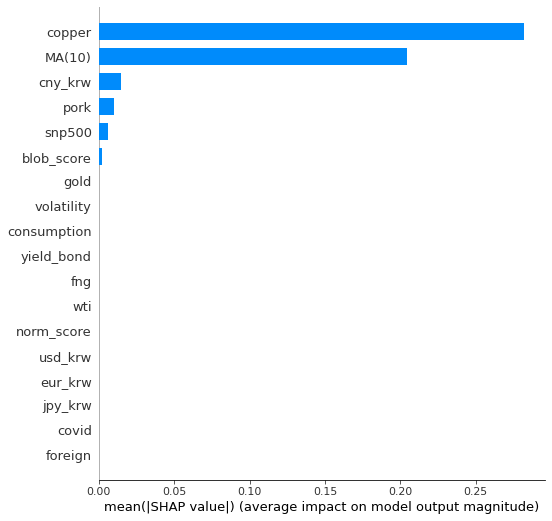

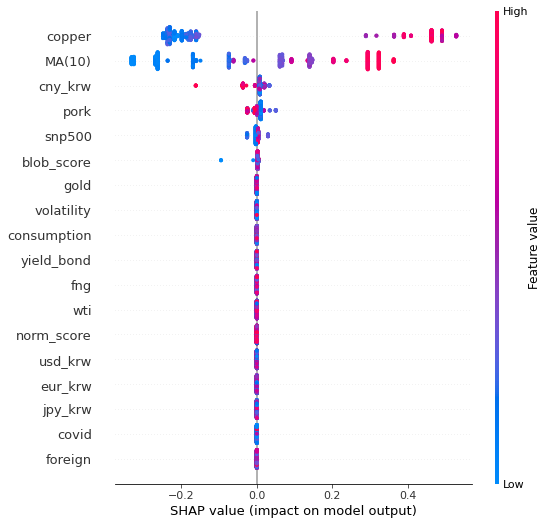

In [19]:
explainer = shap.Explainer(dt, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [20]:
print("Train MSE: ", mean_squared_error(y_train, dt.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, dt_pred))

Train MSE:  0.0025622589767826686

Test MSE:  0.02665749525404988


## Ensemble Methods

### Random Forest

In [21]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
# scores = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=3)
# scores

 97%|=================== | 640/659 [00:31<00:00]       

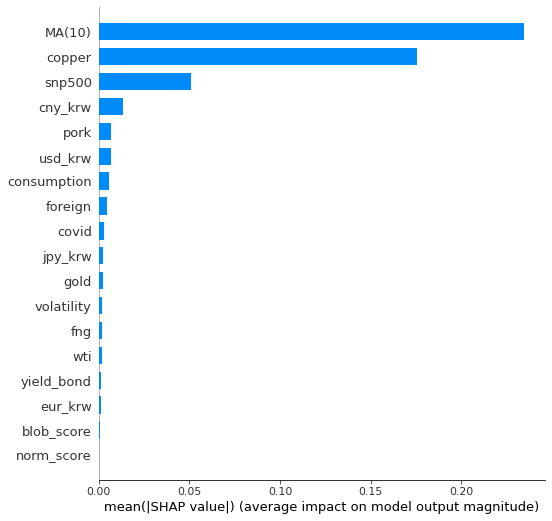

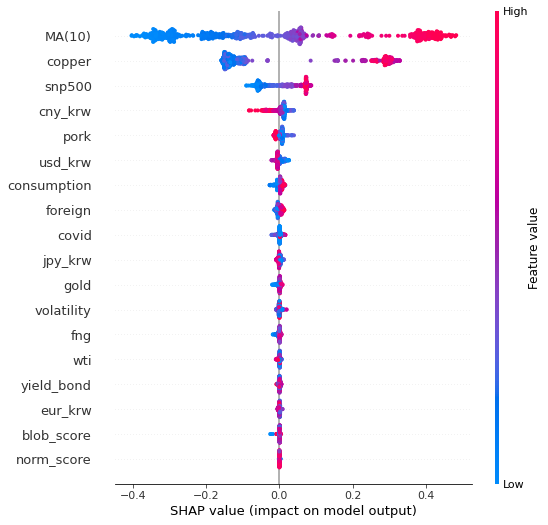

In [22]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_train, check_additivity=False)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [23]:
print("Train MSE: ", mean_squared_error(y_train, rf.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, rf_pred))

Train MSE:  0.00017972575815721682

Test MSE:  0.012720661503693657


### adaBoosting

In [24]:
ada = AdaBoostRegressor(n_estimators=300, random_state=42, learning_rate=0.1)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

In [25]:
feature_importance = ada.feature_importances_

Text(0.5, 1.0, 'Feature Importance')

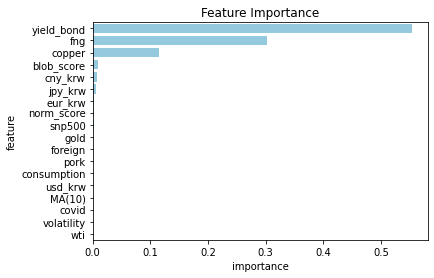

In [26]:
ada_importance = pd.DataFrame({'feature':feature_columns, 
                       'importance':feature_importance})\
    .sort_values('importance',ascending=False)

sns.barplot(x='importance',y='feature', data=ada_importance, color="skyblue").set_title('Feature Importance')

In [27]:
print("Train MSE: ", mean_squared_error(y_train, ada.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, ada_pred))

Train MSE:  0.002384911161787522

Test MSE:  0.01805466152371558


### XGBoosting

In [28]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

[02:14:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


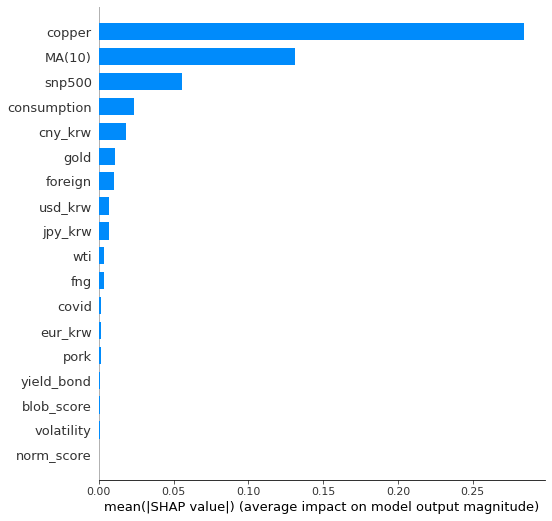

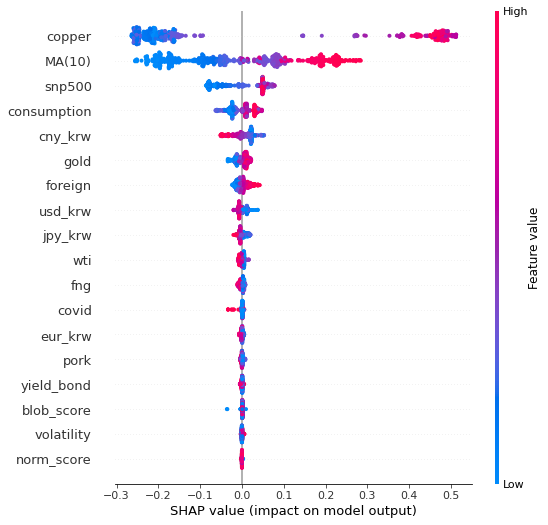

In [29]:
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [30]:
print("Train MSE: ", mean_squared_error(y_train, xgb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, xgb_pred))

Train MSE:  0.0004943051239877107

Test MSE:  0.012669257341321802


### NGBoosting

In [31]:
ngb = NGBRegressor()

ngb.fit(X_train, y_train)
ngb_pred = ngb.predict(X_test)
ngb_dists = ngb.pred_dist(X_test)

[iter 0] loss=0.7389 val_loss=0.0000 scale=2.0000 norm=1.2509
[iter 100] loss=-0.4312 val_loss=0.0000 scale=2.0000 norm=0.9310
[iter 200] loss=-1.3386 val_loss=0.0000 scale=2.0000 norm=0.8970
[iter 300] loss=-2.0367 val_loss=0.0000 scale=2.0000 norm=0.7786
[iter 400] loss=-2.3817 val_loss=0.0000 scale=2.0000 norm=0.7678


Negative Loss
- https://discuss.pytorch.org/t/negative-value-in-my-loss-function/101776

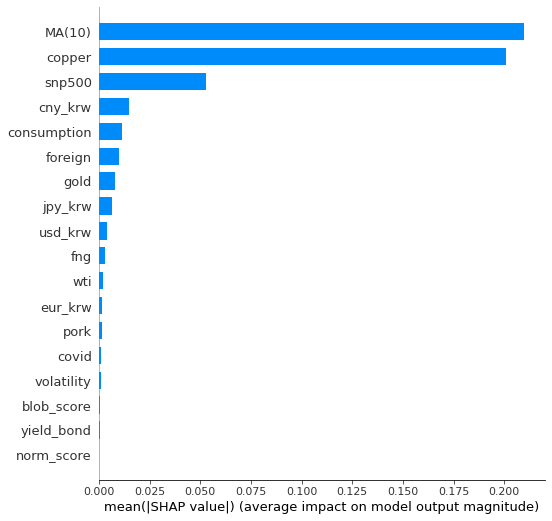

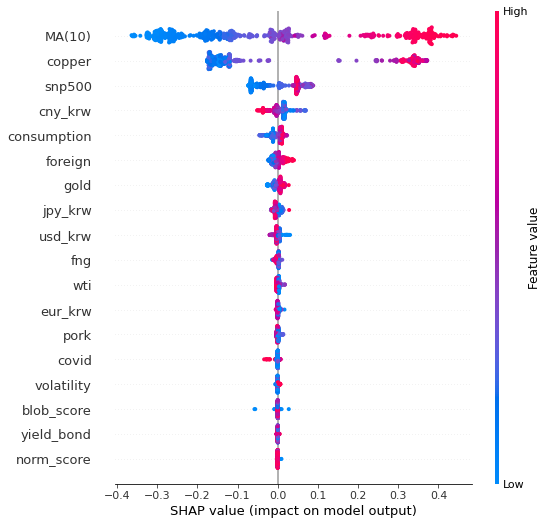

In [32]:
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [33]:
print("Train MSE: ", mean_squared_error(y_train, ngb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, ngb_pred))

Train MSE:  0.000494126273175244

Test MSE:  0.008748047181456631


## Summary

### Prediction + Graph

In [34]:
model_names = [dt, rf, ada, xgb, ngb]

MSE_train = []
MSE_test = []
for model in model_names:
    MSE_train.append(mean_squared_error(y_train, model.predict(X_train)))
    MSE_test.append(mean_squared_error(y_test, model.predict(X_test)))

In [35]:
evaluation = pd.DataFrame([MSE_train, MSE_test],
                          columns = pd.Index(['Decision Tree', 'Random Forest', 'AdaBoosting', 'XGBoosting', 'NGBoosting']),
                          index = pd.Index(['MSE_train', 'MSE_test']))

evaluation

,Decision Tree,Random Forest,AdaBoosting,XGBoosting,NGBoosting
MSE_train,0.002562,0.000180,0.002385,0.000494,0.000494
MSE_test,0.026657,0.012721,0.018055,0.012669,0.008748


### cross_validation

In [36]:
from sklearn import model_selection
model_names = [dt, rf, ada, xgb, ngb]

MSE_train_cv = []
MSE_test_cv = []

for model in model_names:
    tscv = model_selection.TimeSeriesSplit(n_splits=10)
    train_scores = model_selection.cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
    test_scores = model_selection.cross_val_score(model, X_test, y_test, cv=tscv, scoring='neg_mean_absolute_error')
    train_score = np.mean(train_scores) * -1
    test_score = np.mean(test_scores) * -1
    model.fit(X_train, y_train)
    MSE_train_cv.append(mean_squared_error(y_train, model.predict(X_train)))
    MSE_test_cv.append(mean_squared_error(y_test, model.predict(X_test)))

[02:16:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [37]:
evaluation_cv = pd.DataFrame([MSE_train_cv, MSE_test_cv],
                          columns = pd.Index(['Decision Tree', 'Random Forest', 'AdaBoosting', 'XGBoosting', 'NGBoosting']),
                          index = pd.Index(['MSE_train', 'MSE_test']))

evaluation_cv

,Decision Tree,Random Forest,AdaBoosting,XGBoosting,NGBoosting
MSE_train,0.002562,0.000180,0.002385,0.000494,0.000321
MSE_test,0.026657,0.012721,0.018055,0.012669,0.009128


In [38]:
dt_pred.shape

(74,)

In [39]:
dt_pred = dt_pred.reshape(dt_pred.shape[0],1)
dt_pred = np.concatenate((dt_pred, X_test), axis=1)
dt_pred = scaler.inverse_transform(dt_pred)
dt_pred = dt_pred[:,0]

rf_pred = rf_pred.reshape(rf_pred.shape[0],1)
rf_pred = np.concatenate((rf_pred, X_test), axis=1)
rf_pred = scaler.inverse_transform(rf_pred)
rf_pred = rf_pred[:,0]

ada_pred = ada_pred.reshape(ada_pred.shape[0],1)
ada_pred = np.concatenate((ada_pred, X_test), axis=1)
ada_pred = scaler.inverse_transform(ada_pred)
ada_pred = ada_pred[:,0]

xgb_pred = xgb_pred.reshape(xgb_pred.shape[0],1)
xgb_pred = np.concatenate((xgb_pred, X_test), axis=1)
xgb_pred = scaler.inverse_transform(xgb_pred)
xgb_pred = xgb_pred[:,0]

ngb_pred = ngb_pred.reshape(ngb_pred.shape[0],1)
ngb_pred = np.concatenate((ngb_pred, X_test), axis=1)
ngb_pred = scaler.inverse_transform(ngb_pred)
ngb_pred = ngb_pred[:,0]

In [40]:
y_test = y_test.values.reshape(y_test.shape[0],1)
y_test = np.concatenate((y_test, X_test), axis=1)
y_test = scaler.inverse_transform(y_test)


y_test = y_test[:,0]

In [41]:
final_pred = pd.DataFrame({
    'dt': dt_pred,
    'rf': rf_pred,
    'ada': ada_pred,
    'xgb': xgb_pred,
    'ngb': ngb_pred,
    'true': y_test
    # 'lstm': lstm_pred
})

pd.options.display.float_format = '{:.6f}'.format

In [42]:
names = cycle(['dt',	'rf',	'ada', 'xgb',	'ngb', 'true'])

fig = px.line(final_pred[:], x=final_pred.index[:], y=[final_pred['dt'][:],final_pred['rf'][:],
                                          final_pred['ada'][:], final_pred['xgb'][:], final_pred['ngb'][:], final_pred['true'][:]],
             labels={'x': 'Timestamp','value':'Stock close price'})
fig.update_layout(title_text='Final stock analysis chart', font_size=15, font_color='black',legend_title_text='Algorithms')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

### BoxPlot
- https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [ ]:
# from sklearn import model_selection
# from keras.wrappers.scikit_learn import KerasClassifier

# models = []
# # models.append(('SVM', SVR()))
# models.append(('Decision Tree', DecisionTreeRegressor()))
# models.append(('Random Forest', RandomForestRegressor()))
# # models.append(('adaBoosting', AdaBoostRegressor()))
# models.append(('XGBoosting', XGBRegressor()))
# models.append(('CatBoosting', CatBoostRegressor()))
# models.append(('NGBoosting', NGBRegressor()))
# # models.append(('LSTM', lstm))
# # models.append(('GRU', SVC()))

# # evaluate each model in turn
# results = []
# names = []
# scoring = 'r2'
# seed=42

# for name, model in models:
# 	kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
# 	if name != 'LSTM':
# 		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
# 		results.append(cv_results)
# 		names.append(name)
# 		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
# 	else :
# 		lstm = Sequential()
# 		lstm.add(Dense(50, input_dim=18, activation='relu'))
# 		lstm.add(Dense(50, activation='relu'))
# 		lstm.add(Dense(1)) 
# 		lstm.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# 		model = KerasClassifier(build_fn=lstm, epochs=150, batch_size=10, verbose=0)
# 		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
# 		results.append(cv_results)
# 		names.append(name)
# 		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
# 	# print(msg)

# print(results) 

https://snowdeer.github.io/machine-learning/2018/01/09/avoid-overfitting-on-karas/

In [ ]:
# # boxplot algorithm comparison
# fig = plt.figure(figsize=(12,8))
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()

# 2년

# Prepare Data for Analysis

In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df2 = df['2020-01-20':]
df2.reset_index(inplace=True)

In [44]:
training_size = int(len(df2)*0.90)

df2_train = df2.loc[:training_size, :]
df2_test = df2.loc[training_size:, :]

In [45]:
df2_train.drop(['Date'], axis=1, inplace=True)
df2_test.drop(['Date'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
scaler = RobustScaler()
scaler.fit(df2_train)

df2_train[df2_train.columns] = scaler.transform(df2_train[df2_train.columns]) 
df2_test[df2_test.columns] = scaler.transform(df2_test[df2_test.columns]) 
# df2 = pd.DataFrame(scale.fit_transform(df2.values), columns=df2.columns, index=df2.index)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
# feature_columns = list(df2.columns.difference(['Close']))
feature_columns = list(df2_train.columns.difference(['Close']))

In [48]:
y_train = df2_train['Close']
X_train = df2_train.drop(['Close'], axis=1)

y_test = df2_test['Close']
X_test = df2_test.drop(['Close'], axis=1)

## Decision Tree

In [49]:
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [50]:
dt.feature_importances_

array([0.00000000e+00, 4.98092045e-04, 0.00000000e+00, 1.25446454e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.75215013e-01,
       0.00000000e+00, 3.29236338e-03, 6.83381969e-03, 1.10312919e-02,
       0.00000000e+00, 0.00000000e+00, 2.93538393e-03, 0.00000000e+00,
       3.29851495e-04, 9.86097202e-02])

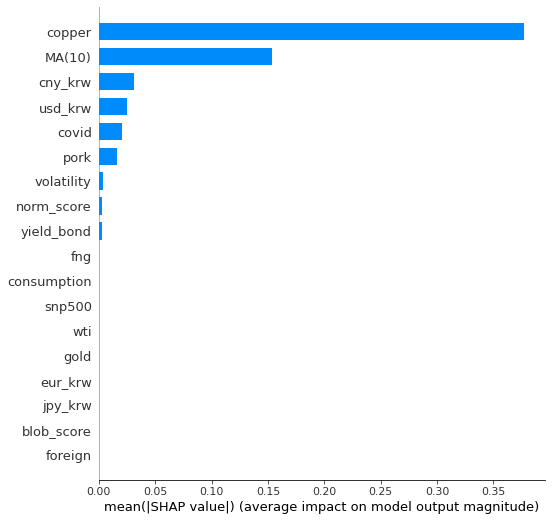

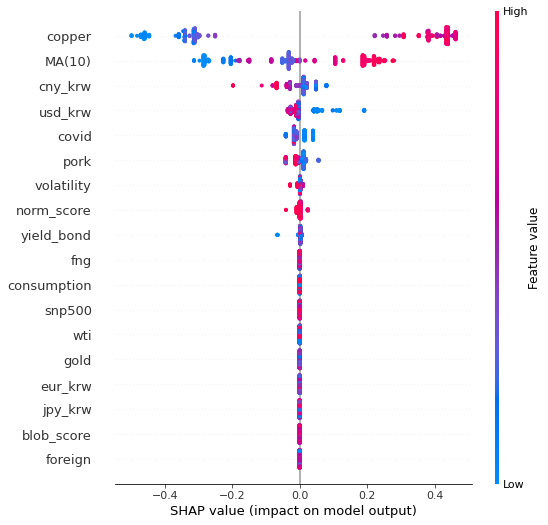

In [51]:
explainer = shap.Explainer(dt, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [52]:
print("Train MSE: ", mean_squared_error(y_train, dt.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, dt_pred))

Train MSE:  0.00319885410433704

Test MSE:  0.017797726203499457


## Ensemble Methods

### Random Forest

In [53]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
# scores = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=3)
# scores

In [54]:
rf.feature_importances_

array([8.07236562e-04, 1.17085672e-03, 2.74725842e-03, 1.15194685e-03,
       5.96831879e-02, 5.76083163e-04, 9.42312030e-04, 4.92133678e-01,
       8.54255841e-04, 2.52774369e-03, 4.38405190e-03, 8.03245123e-03,
       6.21348972e-04, 1.95131104e-03, 2.23730841e-03, 6.19304069e-04,
       2.19311588e-04, 4.19340353e-01])

 99%|===================| 429/435 [00:19<00:00]       

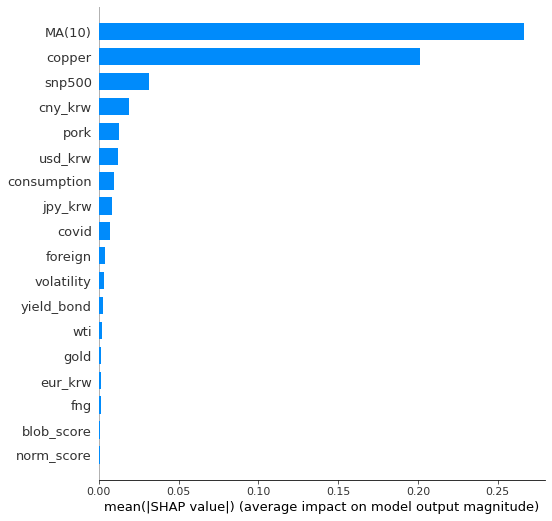

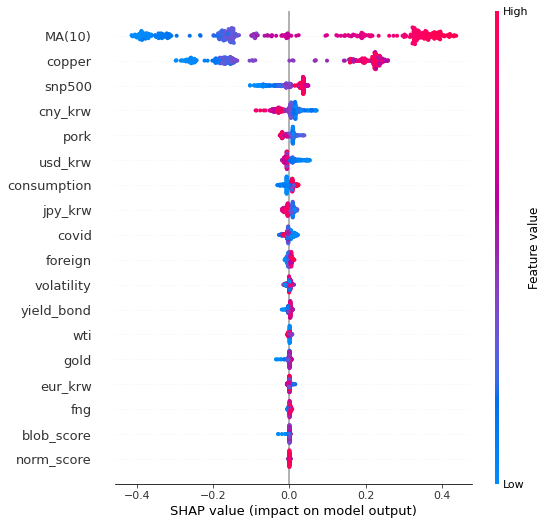

In [55]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_train, check_additivity=False)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [56]:
print("Train MSE: ", mean_squared_error(y_train, rf.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, rf_pred))

Train MSE:  0.00031834744534885184

Test MSE:  0.0074236555876903134


### adaBoosting

In [57]:
ada = AdaBoostRegressor(n_estimators=300, random_state=42, learning_rate=0.1)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

In [58]:
feature_importance = ada.feature_importances_

In [ ]:
feature_importance = ada.feature_importances_

Text(0.5, 1.0, 'Feature Importance')

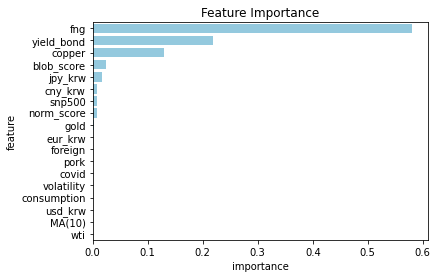

In [59]:
ada_importance = pd.DataFrame({'feature':feature_columns, 
                       'importance':feature_importance})\
    .sort_values('importance',ascending=False)

sns.barplot(x='importance',y='feature', data=ada_importance, color="skyblue").set_title('Feature Importance')

In [60]:
print("Train MSE: ", mean_squared_error(y_train, ada.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, ada_pred))

Train MSE:  0.002745292628919065
Test MSE:  0.0060844460016567115


In [61]:
ada_pred = ada_pred.reshape(ada_pred.shape[0],1)
ada_pred = np.concatenate((ada_pred, X_test), axis=1)
ada_pred = ada_pred[:,0]

### XGBoosting

In [62]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

[02:21:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


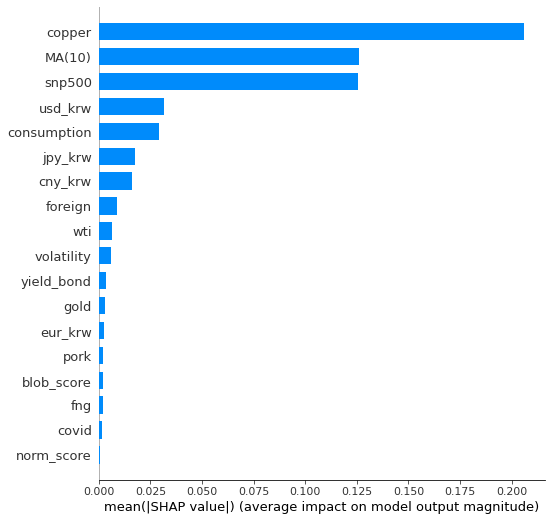

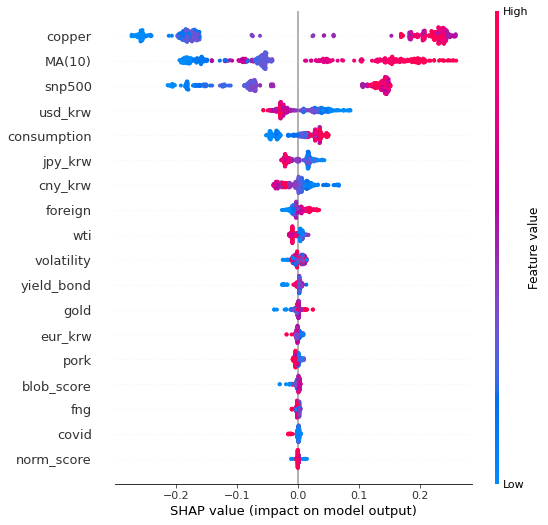

In [63]:
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [64]:
print("Train MSE: ", mean_squared_error(y_train, xgb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, xgb_pred))

Train MSE:  0.0004988939845160989

Test MSE:  0.007369544123838363


### NGBoosting

In [65]:
ngb = NGBRegressor()

ngb.fit(X_train, y_train)
ngb_pred = ngb.predict(X_test)
ngb_dists = ngb.pred_dist(X_test)

[iter 0] loss=0.7774 val_loss=0.0000 scale=1.0000 norm=0.5981
[iter 100] loss=-0.3255 val_loss=0.0000 scale=2.0000 norm=0.9275
[iter 200] loss=-1.2540 val_loss=0.0000 scale=2.0000 norm=0.9159
[iter 300] loss=-1.9980 val_loss=0.0000 scale=2.0000 norm=0.7754
[iter 400] loss=-2.3961 val_loss=0.0000 scale=2.0000 norm=0.7456


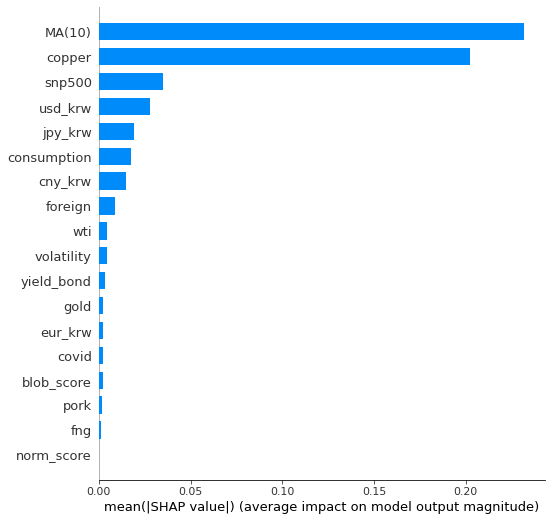

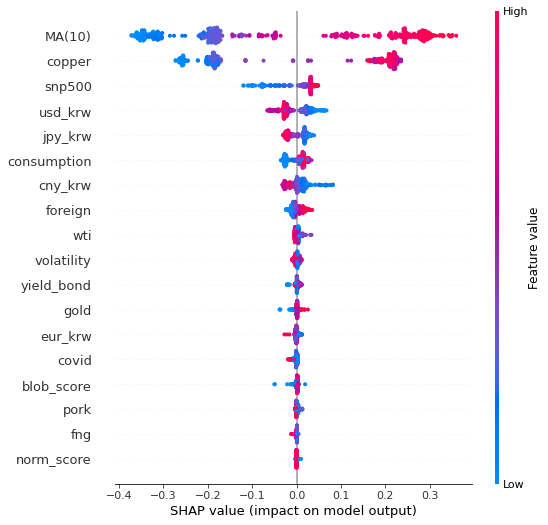

In [66]:
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [67]:
print("Train MSE: ", mean_squared_error(y_train, ngb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, ngb_pred))

Train MSE:  0.00046192288332061893

Test MSE:  0.0073666040455924765


## Summary

### Prediction + Graph

In [68]:
model_names = [dt, rf, ada, xgb, ngb]

MSE_train = []
MSE_test = []
for model in model_names:
    MSE_train.append(mean_squared_error(y_train, model.predict(X_train)))
    MSE_test.append(mean_squared_error(y_test, model.predict(X_test)))

In [69]:
evaluation = pd.DataFrame([MSE_train, MSE_test],
                          columns = pd.Index(['Decision Tree', 'Random Forest', 'AdaBoosting', 'XGBoosting', 'NGBoosting']),
                          index = pd.Index(['MSE_train', 'MSE_test']))

evaluation

,Decision Tree,Random Forest,AdaBoosting,XGBoosting,NGBoosting
MSE_train,0.003199,0.000318,0.002745,0.000499,0.000462
MSE_test,0.017798,0.007424,0.006084,0.007370,0.007367


### cross_validation

In [70]:
from sklearn import model_selection
model_names = [dt, rf, ada, xgb, ngb]

MSE_train_cv = []
MSE_test_cv = []

for model in model_names:
    tscv = model_selection.TimeSeriesSplit(n_splits=10)
    train_scores = model_selection.cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
    test_scores = model_selection.cross_val_score(model, X_test, y_test, cv=tscv, scoring='neg_mean_absolute_error')
    train_score = np.mean(train_scores) * -1
    test_score = np.mean(test_scores) * -1
    model.fit(X_train, y_train)
    MSE_train_cv.append(mean_squared_error(y_train, model.predict(X_train)))
    MSE_test_cv.append(mean_squared_error(y_test, model.predict(X_test)))

[02:23:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [71]:
evaluation_cv = pd.DataFrame([MSE_train_cv, MSE_test_cv],
                          columns = pd.Index(['Decision Tree', 'Random Forest', 'AdaBoosting', 'XGBoosting', 'NGBoosting']),
                          index = pd.Index(['MSE_train', 'MSE_test']))

evaluation_cv

,Decision Tree,Random Forest,AdaBoosting,XGBoosting,NGBoosting
MSE_train,0.003199,0.000318,0.002745,0.000499,0.000275
MSE_test,0.017798,0.007424,0.006084,0.007370,0.006674


In [72]:
dt_pred = dt_pred.reshape(dt_pred.shape[0],1)
dt_pred = np.concatenate((dt_pred, X_test), axis=1)
dt_pred = scaler.inverse_transform(dt_pred)
dt_pred = dt_pred[:,0]

rf_pred = rf_pred.reshape(rf_pred.shape[0],1)
rf_pred = np.concatenate((rf_pred, X_test), axis=1)
rf_pred = scaler.inverse_transform(rf_pred)
rf_pred = rf_pred[:,0]

ada_pred = ada_pred.reshape(ada_pred.shape[0],1)
ada_pred = np.concatenate((ada_pred, X_test), axis=1)
ada_pred = scaler.inverse_transform(ada_pred)
ada_pred = ada_pred[:,0]

xgb_pred = xgb_pred.reshape(xgb_pred.shape[0],1)
xgb_pred = np.concatenate((xgb_pred, X_test), axis=1)
xgb_pred = scaler.inverse_transform(xgb_pred)
xgb_pred = xgb_pred[:,0]

ngb_pred = ngb_pred.reshape(ngb_pred.shape[0],1)
ngb_pred = np.concatenate((ngb_pred, X_test), axis=1)
ngb_pred = scaler.inverse_transform(ngb_pred)
ngb_pred = ngb_pred[:,0]

In [73]:
y_test = y_test.values.reshape(y_test.shape[0],1)
y_test = np.concatenate((y_test, X_test), axis=1)
y_test = scaler.inverse_transform(y_test)
y_test = y_test[:,0]

In [74]:
final_pred = pd.DataFrame({
    'dt': dt_pred,
    'rf': rf_pred,
    'ada': ada_pred,
    'xgb': xgb_pred,
    'ngb': ngb_pred,
    'true': y_test
})


In [75]:
names = cycle(['dt',	'rf',	'ada', 'xgb',	'ngb', 'true'])

fig = px.line(final_pred[:], x=final_pred.index[:], y=[final_pred['dt'][:],final_pred['rf'][:],
                                          final_pred['ada'][:], final_pred['xgb'][:], final_pred['ngb'][:], final_pred['true'][:]],
             labels={'x': 'Timestamp','value':'Stock close price'})
fig.update_layout(title_text='Final stock analysis chart', font_size=15, font_color='black',legend_title_text='Algorithms')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

### BoxPlot
- https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [ ]:
# from sklearn import model_selection
# from keras.wrappers.scikit_learn import KerasClassifier

# models = []
# # models.append(('SVM', SVR()))
# models.append(('Decision Tree', DecisionTreeRegressor()))
# models.append(('Random Forest', RandomForestRegressor()))
# # models.append(('adaBoosting', AdaBoostRegressor()))
# models.append(('XGBoosting', XGBRegressor()))
# models.append(('CatBoosting', CatBoostRegressor()))
# models.append(('NGBoosting', NGBRegressor()))
# # models.append(('LSTM', lstm))
# # models.append(('GRU', SVC()))

# # evaluate each model in turn
# results = []
# names = []
# scoring = 'r2'
# seed=42

# for name, model in models:
# 	kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
# 	if name != 'LSTM':
# 		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
# 		results.append(cv_results)
# 		names.append(name)
# 		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
# 	else :
# 		lstm = Sequential()
# 		lstm.add(Dense(50, input_dim=18, activation='relu'))
# 		lstm.add(Dense(50, activation='relu'))
# 		lstm.add(Dense(1)) 
# 		lstm.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# 		model = KerasClassifier(build_fn=lstm, epochs=150, batch_size=10, verbose=0)
# 		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
# 		results.append(cv_results)
# 		names.append(name)
# 		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
# 	# print(msg)

# print(results) 

https://snowdeer.github.io/machine-learning/2018/01/09/avoid-overfitting-on-karas/

In [ ]:
# # boxplot algorithm comparison
# fig = plt.figure(figsize=(12,8))
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()

# 1년

# Prepare Data for Analysis

In [ ]:
df1 = df['2021-01-01':]
df1.reset_index(inplace=True)

In [ ]:
training_size = int(len(df1)*0.90)

df1_train = df1.loc[:training_size, :]
df1_test = df1.loc[training_size:, :]

In [ ]:
df1_train.drop(['Date'], axis=1, inplace=True)
df1_test.drop(['Date'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
scaler = RobustScaler()
scaler.fit(df1_train)

df1_train[df1_train.columns] = scaler.transform(df1_train[df1_train.columns]) 
df1_test[df1_test.columns] = scaler.transform(df1_test[df1_test.columns]) 
# df1 = pd.DataFrame(scale.fit_transform(df1.values), columns=df1.columns, index=df1.index)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# feature_columns = list(df2.columns.difference(['Close']))
feature_columns = list(df2_train.columns.difference(['Close']))

In [ ]:
y_train = df1_train['Close']
X_train = df1_train.drop(['Close'], axis=1)

y_test = df1_test['Close']
X_test = df1_test.drop(['Close'], axis=1)

## Decision Tree

In [ ]:
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [ ]:
dt.feature_importances_

array([0.00463681, 0.        , 0.01526813, 0.07132297, 0.01774028,
       0.        , 0.        , 0.00258945, 0.00248731, 0.04464577,
       0.67399241, 0.16139971, 0.        , 0.        , 0.        ,
       0.00591716])

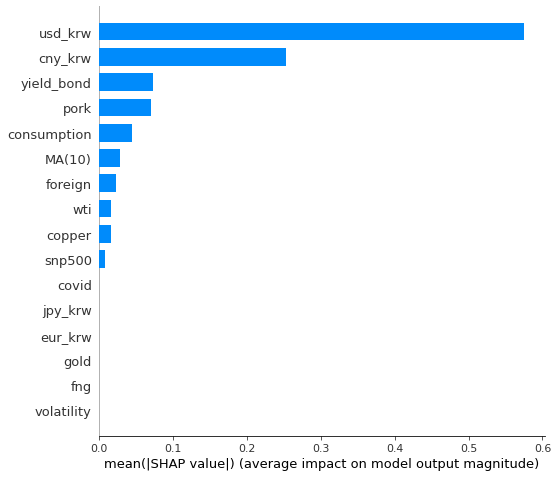

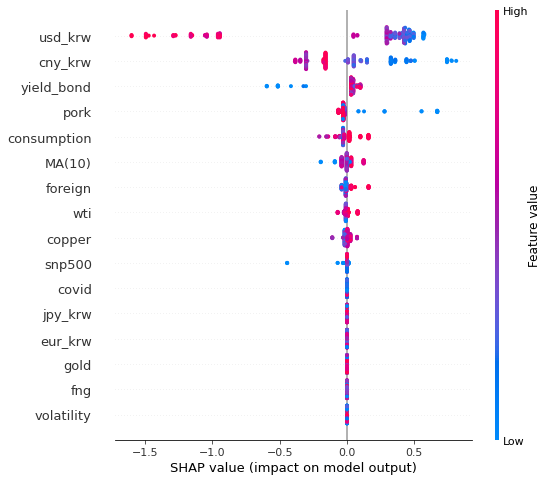

In [ ]:
explainer = shap.Explainer(dt, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [ ]:
print("Train MSE: ", mean_squared_error(y_train, dt.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, dt_pred))

Train MSE:  0.04390884224158783

Test MSE:  0.48978274667988686


## Ensemble Methods

### Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
# scores = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=3)
# scores

In [ ]:
rf.feature_importances_

array([0.00758284, 0.02906596, 0.01578721, 0.04691135, 0.00723862,
       0.00724867, 0.00619355, 0.00622727, 0.01263934, 0.0496797 ,
       0.36435795, 0.40052496, 0.00546473, 0.00569512, 0.00477858,
       0.03060414])

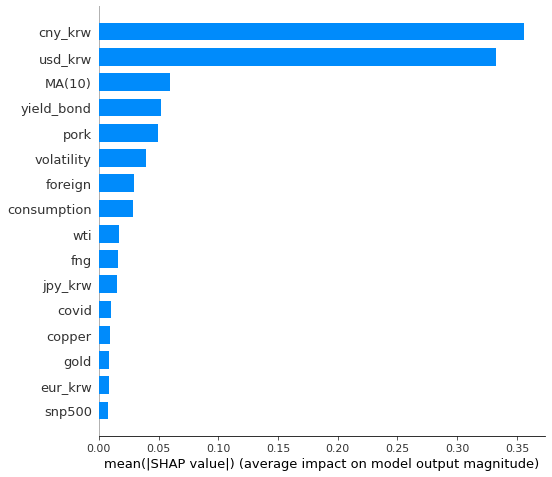

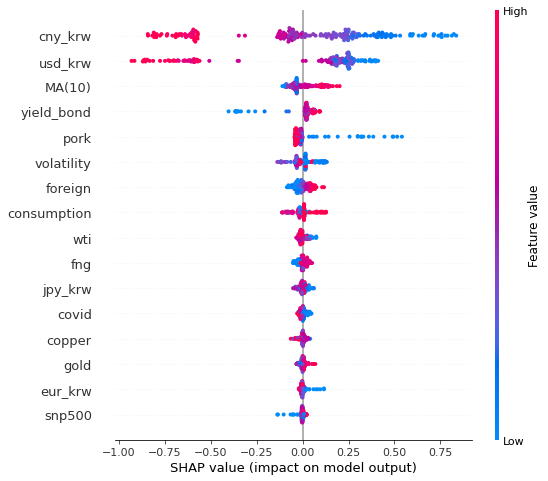

In [ ]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_train, check_additivity=False)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [ ]:
print("Train MSE: ", mean_squared_error(y_train, rf.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, rf_pred))

Train MSE:  0.010881327813013847

Test MSE:  0.4512174280692256


### adaBoosting

In [ ]:
ada = AdaBoostRegressor(n_estimators=300, random_state=42, learning_rate=0.1)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

In [ ]:
feature_importance = ada.feature_importances_

Text(0.5, 1.0, 'Feature Importance')

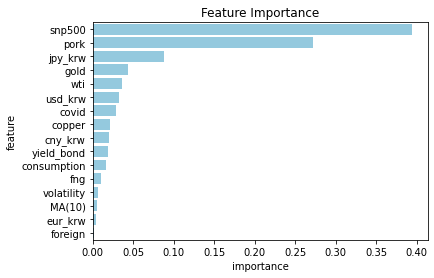

In [ ]:
ada_importance = pd.DataFrame({'feature':feature_columns, 
                       'importance':feature_importance})\
    .sort_values('importance',ascending=False)

sns.barplot(x='importance',y='feature', data=ada_importance, color="skyblue").set_title('Feature Importance')

In [ ]:
print("Train MSE: ", mean_squared_error(y_train, ada.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, ada_pred))

Train MSE:  0.035804537262431796
Test MSE:  0.4719005736017192


In [ ]:
ada_pred = ada_pred.reshape(ada_pred.shape[0],1)
ada_pred = np.concatenate((ada_pred, X_test), axis=1)
ada_pred = ada_pred[:,0]

### XGBoosting

In [ ]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

[07:18:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


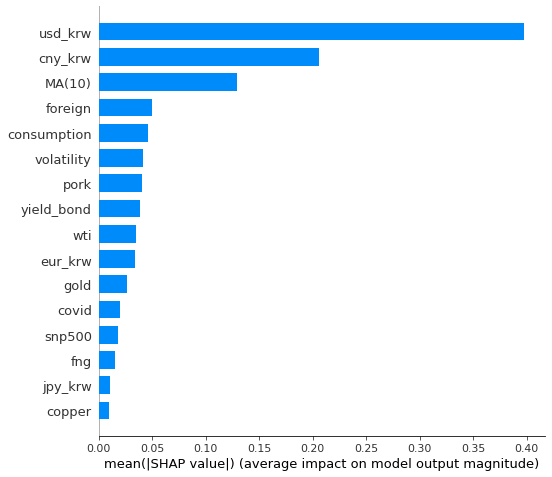

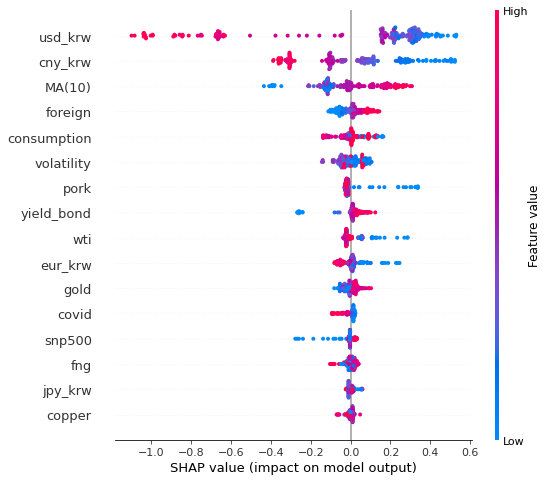

In [ ]:
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [ ]:
print("Train MSE: ", mean_squared_error(y_train, xgb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, xgb_pred))

Train MSE:  0.005291982487382271

Test MSE:  0.32868726213443905


### NGBoosting

In [ ]:
ngb = NGBRegressor()

ngb.fit(X_train, y_train)
ngb_pred = ngb.predict(X_test)
ngb_dists = ngb.pred_dist(X_test)

[iter 0] loss=1.4168 val_loss=0.0000 scale=1.0000 norm=0.9987
[iter 100] loss=0.3533 val_loss=0.0000 scale=2.0000 norm=0.9828
[iter 200] loss=-0.3940 val_loss=0.0000 scale=2.0000 norm=0.8157
[iter 300] loss=-0.8861 val_loss=0.0000 scale=2.0000 norm=0.7179
[iter 400] loss=-1.1522 val_loss=0.0000 scale=2.0000 norm=0.6691


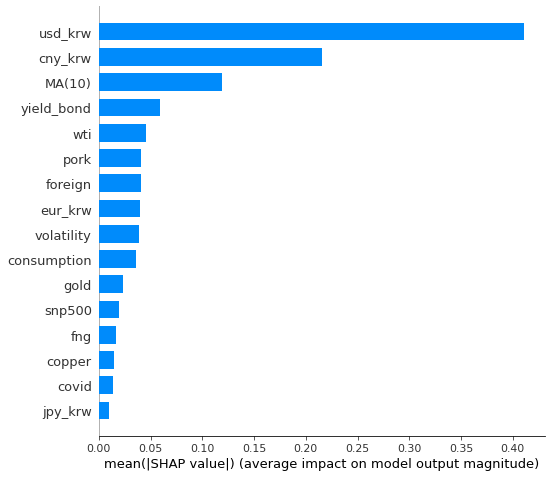

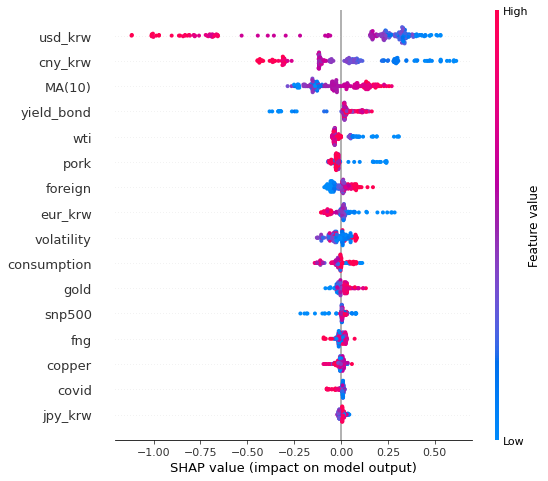

In [ ]:
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [ ]:
print("Train MSE: ", mean_squared_error(y_train, ngb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, ngb_pred))

Train MSE:  0.005707671348119729

Test MSE:  0.30553699424225866


## Summary

### Prediction + Graph

In [ ]:
model_names = [dt, rf, ada, xgb, ngb]

MSE_train = []
MSE_test = []
for model in model_names:
    MSE_train.append(mean_squared_error(y_train, model.predict(X_train)))
    MSE_test.append(mean_squared_error(y_test, model.predict(X_test)))

In [ ]:
evaluation = pd.DataFrame([MSE_train, MSE_test],
                          columns = pd.Index(['Decision Tree', 'Random Forest', 'AdaBoosting', 'XGBoosting', 'NGBoosting']),
                          index = pd.Index(['MSE_train', 'MSE_test']))

evaluation

,Decision Tree,Random Forest,AdaBoosting,XGBoosting,NGBoosting
MSE_train,0.043909,0.010881,0.035805,0.005292,0.005708
MSE_test,0.489783,0.451217,0.471901,0.328687,0.305537


### cross_validation

In [ ]:
from sklearn import model_selection
model_names = [dt, rf, ada, xgb, ngb]

MSE_train_cv = []
MSE_test_cv = []

for model in model_names:
    tscv = model_selection.TimeSeriesSplit(n_splits=10)
    train_scores = model_selection.cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
    test_scores = model_selection.cross_val_score(model, X_test, y_test, cv=tscv, scoring='neg_mean_absolute_error')
    train_score = np.mean(train_scores) * -1
    test_score = np.mean(test_scores) * -1
    model.fit(X_train, y_train)
    MSE_train_cv.append(mean_squared_error(y_train, model.predict(X_train)))
    MSE_test_cv.append(mean_squared_error(y_test, model.predict(X_test)))

[07:18:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:18:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:18:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:18:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:18:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:18:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:18:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:18:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
evaluation_cv = pd.DataFrame([MSE_train_cv, MSE_test_cv],
                          columns = pd.Index(['Decision Tree', 'Random Forest', 'AdaBoosting', 'XGBoosting', 'NGBoosting']),
                          index = pd.Index(['MSE_train', 'MSE_test']))

evaluation_cv

,Decision Tree,Random Forest,AdaBoosting,XGBoosting,NGBoosting
MSE_train,0.043909,0.010881,0.035805,0.005292,0.002409
MSE_test,0.489783,0.451217,0.471901,0.328687,0.277196


In [ ]:
dt_pred = dt_pred.reshape(dt_pred.shape[0],1)
dt_pred = np.concatenate((dt_pred, X_test), axis=1)
dt_pred = scaler.inverse_transform(dt_pred)
dt_pred = dt_pred[:,0]

rf_pred = rf_pred.reshape(rf_pred.shape[0],1)
rf_pred = np.concatenate((rf_pred, X_test), axis=1)
rf_pred = scaler.inverse_transform(rf_pred)
rf_pred = rf_pred[:,0]

ada_pred = ada_pred.reshape(ada_pred.shape[0],1)
ada_pred = np.concatenate((ada_pred, X_test), axis=1)
ada_pred = scaler.inverse_transform(ada_pred)
ada_pred = ada_pred[:,0]

xgb_pred = xgb_pred.reshape(xgb_pred.shape[0],1)
xgb_pred = np.concatenate((xgb_pred, X_test), axis=1)
xgb_pred = scaler.inverse_transform(xgb_pred)
xgb_pred = xgb_pred[:,0]

ngb_pred = ngb_pred.reshape(ngb_pred.shape[0],1)
ngb_pred = np.concatenate((ngb_pred, X_test), axis=1)
ngb_pred = scaler.inverse_transform(ngb_pred)
ngb_pred = ngb_pred[:,0]

In [ ]:
y_test = y_test.values.reshape(y_test.shape[0],1)
y_test = np.concatenate((y_test, X_test), axis=1)
y_test = scaler.inverse_transform(y_test)
y_test = y_test[:,0]

In [ ]:
final_pred = pd.DataFrame({
    'dt': dt_pred,
    'rf': rf_pred,
    'ada': ada_pred,
    'xgb': xgb_pred,
    'ngb': ngb_pred,
    'true': y_test
    # 'lstm': lstm_pred
})


In [ ]:
names = cycle(['dt',	'rf',	'ada', 'xgb',	'ngb', 'true'])

fig = px.line(final_pred[:], x=final_pred.index[:], y=[final_pred['dt'][:],final_pred['rf'][:],
                                          final_pred['ada'][:], final_pred['xgb'][:], final_pred['ngb'][:], final_pred['true'][:]],
             labels={'x': 'Timestamp','value':'Stock close price'})
fig.update_layout(title_text='Final stock analysis chart', font_size=15, font_color='black',legend_title_text='Algorithms')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

### BoxPlot
- https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [ ]:
# from sklearn import model_selection
# from keras.wrappers.scikit_learn import KerasClassifier

# models = []
# # models.append(('SVM', SVR()))
# models.append(('Decision Tree', DecisionTreeRegressor()))
# models.append(('Random Forest', RandomForestRegressor()))
# # models.append(('adaBoosting', AdaBoostRegressor()))
# models.append(('XGBoosting', XGBRegressor()))
# models.append(('CatBoosting', CatBoostRegressor()))
# models.append(('NGBoosting', NGBRegressor()))
# # models.append(('LSTM', lstm))
# # models.append(('GRU', SVC()))

# # evaluate each model in turn
# results = []
# names = []
# scoring = 'r2'
# seed=42

# for name, model in models:
# 	kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
# 	if name != 'LSTM':
# 		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
# 		results.append(cv_results)
# 		names.append(name)
# 		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
# 	else :
# 		lstm = Sequential()
# 		lstm.add(Dense(50, input_dim=18, activation='relu'))
# 		lstm.add(Dense(50, activation='relu'))
# 		lstm.add(Dense(1)) 
# 		lstm.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# 		model = KerasClassifier(build_fn=lstm, epochs=150, batch_size=10, verbose=0)
# 		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
# 		results.append(cv_results)
# 		names.append(name)
# 		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
# 	# print(msg)

# print(results) 

https://snowdeer.github.io/machine-learning/2018/01/09/avoid-overfitting-on-karas/

In [ ]:
# # boxplot algorithm comparison
# fig = plt.figure(figsize=(12,8))
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()

# Better Visualization
- https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0